# Regression modeling with Traffic + Population Data

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pprint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from math import sqrt
from sklearn import ensemble
from sklearn.inspection import permutation_importance

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, explained_variance_score
import xgboost as xgb
import uuid 
%matplotlib inline


In [3]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

In [4]:
df = pd.read_csv("./data/traffic_pop_data.csv")

In [5]:
df.head()

,Severity,StartTime(UTC),LocationLat,LocationLng,ZipCode,Duration,irs_estimated_population_2015,County,Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),Population Estimate (as of July 1) - 2018 - Male; Median age (years),Population Estimate (as of July 1) - 2018 - Female; Median age (years),Density(/sqmi)
0,1,2016-11-30 23:35:00,47.01,-122.91,98501,80,37370,Thurston,39.10,37.70,40.50,335.30
1,2,2016-12-01 00:52:00,47.61,-122.33,98104,12,8990,King,36.90,36.20,37.70,870.90
2,1,2016-12-01 01:08:00,47.96,-122.20,98203,18,32440,Snohomish,38.00,37.20,38.80,334.80
3,1,2016-12-01 01:02:00,47.56,-122.19,98006,22,39630,King,36.90,36.20,37.70,870.90
4,1,2016-12-01 01:19:00,47.62,-122.33,98101,12,10910,King,36.90,36.20,37.70,870.90


In [6]:
df_prune = df.copy()

In [7]:
df_prune.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557498 entries, 0 to 557497
Data columns (total 12 columns):
 #   Column                                                                      Non-Null Count   Dtype  
---  ------                                                                      --------------   -----  
 0   Severity                                                                    557498 non-null  int64  
 1   StartTime(UTC)                                                              557498 non-null  object 
 2   LocationLat                                                                 557498 non-null  float64
 3   LocationLng                                                                 557498 non-null  float64
 4   ZipCode                                                                     557498 non-null  int64  
 5   Duration                                                                    557498 non-null  int64  
 6   irs_estimated_population_2015       

In [8]:
def Mon(x):
    return x.split(" ")[0].split('-')[1]
def Day(x):
    return x.split(" ")[0].split('-')[2]
def Hour(x):
    return x.split(" ")[1].split(':')[0]
def Minute(x):
    return x.split(" ")[1].split(':')[1]

In [9]:
df_prune['StartMonth'] = df_prune['StartTime(UTC)'].apply(lambda x: Mon(x)).astype(int)
df_prune['StartDay'] = df_prune['StartTime(UTC)'].apply(lambda x: Day(x)).astype(int)
df_prune['StartHour'] = df_prune['StartTime(UTC)'].apply(lambda x: Hour(x)).astype(int)
df_prune['StartMinute'] = df_prune['StartTime(UTC)'].apply(lambda x: Minute(x)).astype(int)

In [10]:
df_prune['StartTime(UTC)'] = pd.to_datetime(df_prune['StartTime(UTC)'])

def get_dayofweek(x):
    return x.dayofweek
df_prune['DayOfWeek'] = df_prune['StartTime(UTC)'].apply(lambda x: get_dayofweek(x)).astype(int)

In [12]:
df_prune.head(2)

,Severity,StartTime(UTC),LocationLat,LocationLng,ZipCode,Duration,irs_estimated_population_2015,County,Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),Population Estimate (as of July 1) - 2018 - Male; Median age (years),Population Estimate (as of July 1) - 2018 - Female; Median age (years),Density(/sqmi),StartMonth,StartDay,StartHour,StartMinute,DayOfWeek
0,1,2016-11-30 23:35:00,47.01,-122.91,98501,80,37370,Thurston,39.10,37.70,40.50,335.30,11,30,23,35,2
1,2,2016-12-01 00:52:00,47.61,-122.33,98104,12,8990,King,36.90,36.20,37.70,870.90,12,1,0,52,3


### Basic EDA (Monthly, Weekly, Daily, Hourly congestion Charts)

In [16]:
df_monthly = df_prune.groupby('StartMonth')['Duration'].mean().reset_index()
df_weekly = df_prune.groupby('DayOfWeek')['Duration'].mean().reset_index()
df_daily = df_prune.groupby('StartDay')['Duration'].mean().reset_index()
df_hourly = df_prune.groupby('StartHour')['Duration'].mean().reset_index()

Text(0.5, 0, 'Month')

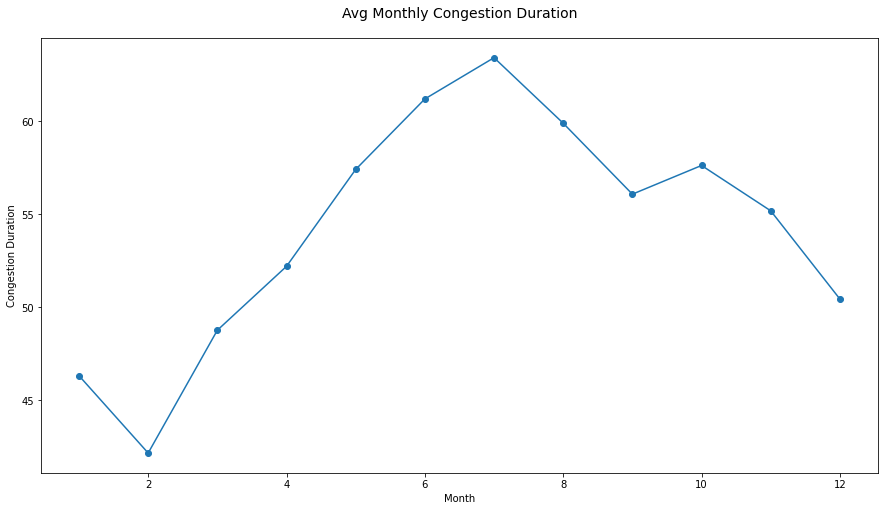

In [31]:
plt.figure(figsize=(15,8))
plt.title('Avg Monthly Congestion Duration', pad = 20, fontdict={'size':14})
plt.plot(df_monthly['StartMonth'], df_monthly['Duration'])
plt.scatter(df_monthly['StartMonth'], df_monthly['Duration'])
plt.ylabel('Congestion Duration')
plt.xlabel('Month')

Text(0.5, 0, 'Day')

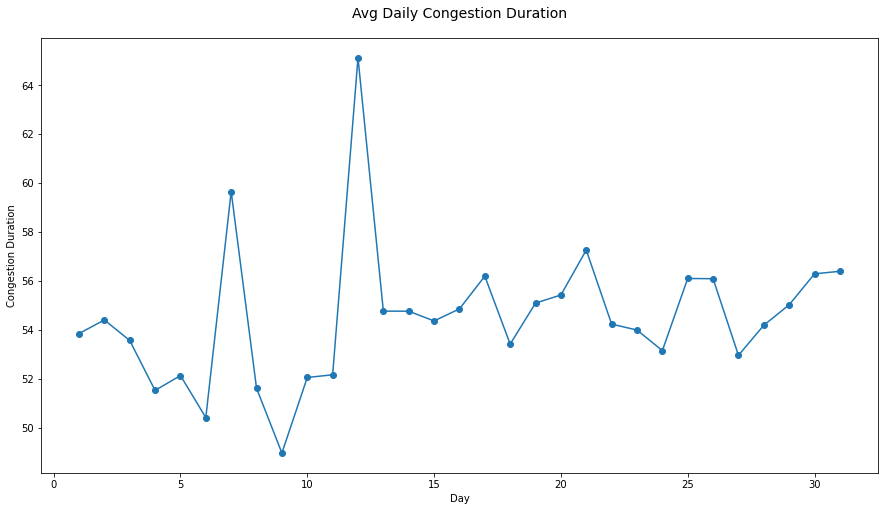

In [33]:
plt.figure(figsize=(15,8))
plt.title('Avg Daily Congestion Duration', pad = 20, fontdict={'size':14})
plt.plot(df_daily['StartDay'], df_daily['Duration'])
plt.scatter(df_daily['StartDay'], df_daily['Duration'])
plt.ylabel('Congestion Duration')
plt.xlabel('Day')

Text(0.5, 0, 'Weekday')

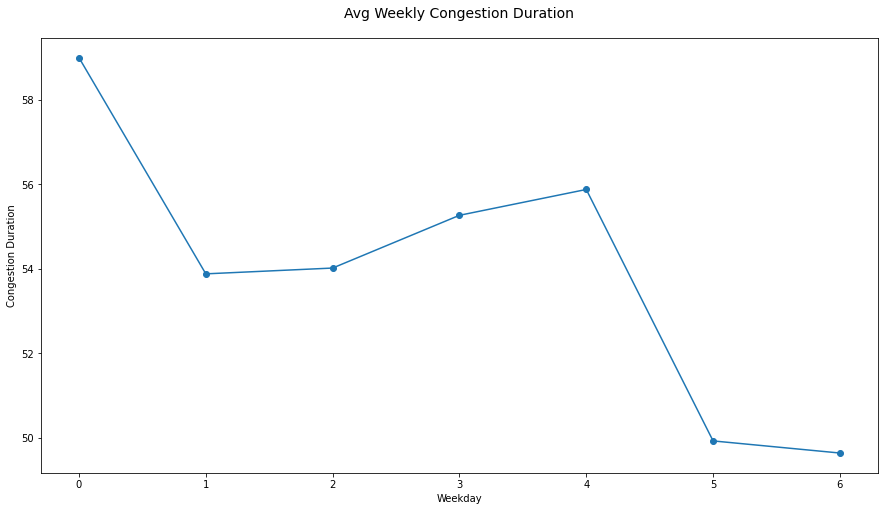

In [32]:
plt.figure(figsize=(15,8))
plt.title('Avg Weekly Congestion Duration', pad = 20, fontdict={'size':14})
plt.plot(df_weekly['DayOfWeek'], df_weekly['Duration'])
plt.scatter(df_weekly['DayOfWeek'], df_weekly['Duration'])
plt.ylabel('Congestion Duration')
plt.xlabel('Weekday')

Text(0.5, 0, 'Hour')

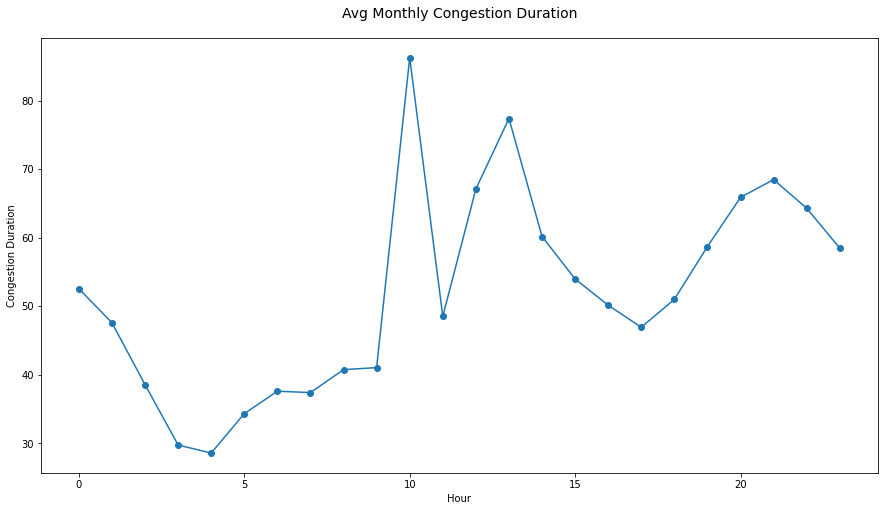

In [34]:
plt.figure(figsize=(15,8))
plt.title('Avg Monthly Congestion Duration', pad = 20, fontdict={'size':14})
plt.plot(df_hourly['StartHour'], df_hourly['Duration'])
plt.scatter(df_hourly['StartHour'], df_hourly['Duration'])
plt.ylabel('Congestion Duration')
plt.xlabel('Hour')

In [12]:
df_prune.drop('StartTime(UTC)', inplace=True, axis = 1)

In [13]:
df_prune.isnull().sum().sum()

0

In [14]:
len(df_prune)

557498

In [15]:
df_prune.dropna(inplace=True)

In [16]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df_prune['County'] = le.fit_transform(df_prune['County'])


In [17]:
df_prune.head()

,Severity,LocationLat,LocationLng,ZipCode,Duration,irs_estimated_population_2015,County,Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),Population Estimate (as of July 1) - 2018 - Male; Median age (years),Population Estimate (as of July 1) - 2018 - Female; Median age (years),Density(/sqmi),StartMonth,StartDay,StartHour,StartMinute,DayOfWeek
0,1,47.01,-122.91,98501,80,37370,32,39.10,37.70,40.50,335.30,11,30,23,35,2
1,2,47.61,-122.33,98104,12,8990,16,36.90,36.20,37.70,870.90,12,1,0,52,3
2,1,47.96,-122.20,98203,18,32440,29,38.00,37.20,38.80,334.80,12,1,1,8,3
3,1,47.56,-122.19,98006,22,39630,16,36.90,36.20,37.70,870.90,12,1,1,2,3
4,1,47.62,-122.33,98101,12,10910,16,36.90,36.20,37.70,870.90,12,1,1,19,3


In [18]:
# (month:label) --- (1-3 : 0), (4-6 : 1), (7-9 : 2), (10-12 : 3)
df_prune['Season'] = np.where((df_prune['StartMonth']<=3), 0, 
                                  np.where((df_prune['StartMonth']>3) & (df_prune['StartMonth']<=6), 1,
                                          np.where((df_prune['StartMonth']>6) & (df_prune['StartMonth']<=9), 2, 3))
                                  )

In [19]:
# (day:label) --- (1-7 : 0), (8-15 : 1), (16-23 : 2), (24-28+ : 3)
df_prune['WeekofMonth'] = np.where((df_prune['StartDay']<=7), 0, 
                                  np.where((df_prune['StartDay']>8) & (df_prune['StartDay']<=15), 1,
                                          np.where((df_prune['StartDay']>16) & (df_prune['StartDay']<=23), 2, 3))
                                  )

In [20]:
# (hour:label) --- (1-6 : 0), (7-12 : 1), (13-18 : 2), (19-24 : 3)
df_prune['HourOfDay'] = np.where((df_prune['StartHour']<=7), 0, 
                                  np.where((df_prune['StartHour']>8) & (df_prune['StartHour']<=15), 1,
                                          np.where((df_prune['StartHour']>16) & (df_prune['StartHour']<=23), 2, 3))
                                  )

In [21]:
# (minute:label) --- (1-15 : 0), (16-30 : 1), (31-45 : 2), (46-60 : 3)
df_prune['MinuteOfHour'] = np.where((df_prune['StartMinute']<=7), 0, 
                                  np.where((df_prune['StartMinute']>8) & (df_prune['StartMinute']<=15), 1,
                                          np.where((df_prune['StartMinute']>16) & (df_prune['StartMinute']<=23), 2, 3))
                                  )

In [22]:
df_prune.drop(['irs_estimated_population_2015', 
               'Population Estimate (as of July 1) - 2018 - Male; Median age (years)', 
               'Population Estimate (as of July 1) - 2018 - Female; Median age (years)', 
               'StartMonth', 
               'StartDay', 
               'StartHour', 
               'StartMinute',
              'County'], 
              axis = 1,
              inplace=True)

In [23]:
df_prune.head()

,Severity,LocationLat,LocationLng,ZipCode,Duration,Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),Density(/sqmi),DayOfWeek,Season,WeekofMonth,HourOfDay,MinuteOfHour
0,1,47.01,-122.91,98501,80,39.10,335.30,2,3,3,2,3
1,2,47.61,-122.33,98104,12,36.90,870.90,3,3,0,0,3
2,1,47.96,-122.20,98203,18,38.00,334.80,3,3,0,0,3
3,1,47.56,-122.19,98006,22,36.90,870.90,3,3,0,0,0
4,1,47.62,-122.33,98101,12,36.90,870.90,3,3,0,0,2


In [340]:
# df_prune['rec_id'] = [uuid.uuid4() for _ in range(len(df_prune.index))]
# df_prune.drop('rec_id', axis = 1, inplace=True)

In [335]:
df_data,  df_target= df_prune.drop('Duration', axis = 1), df_prune['Duration']

In [280]:
# df_data.rename(columns={'index_': 'index1'}, inplace=True)
# df_target.rename(columns={'index__': 'index2'}, inplace=True)

In [268]:
import featuretools as ft

In [345]:
es.entity_from_dataframe(entity_id='data',
                         dataframe=df_data,
                         make_index=True,
                         index='index')

feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_entity='data',
    trans_primitives=['add_numeric', 'multiply_numeric'])

In [24]:
def RSquare(df, col):
    X, y = df.drop(col,axis=1), df[col]

    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    X, y = np.array(X), np.array(y)
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 50)
    cv_lm_r2s, cv_lm_reg_r2s, cv_lm_poly_r2s, cv_lasso_r2s = [], [], [], [] #collect the validation results for both models

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        #simple linear regression
        lm = LinearRegression()
        lm_reg = Ridge(alpha=1)
        lm_poly = LinearRegression()

        lm.fit(X_train, y_train)
        cv_lm_r2s.append(lm.score(X_val, y_val))
#         cv_lm_r2s.append(lm.score(X_tra, y_tra))

        #ridge with feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        lm_reg.fit(X_train_scaled, y_train)
        cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

        poly = PolynomialFeatures(degree=2) 
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
        lm_poly.fit(X_train_poly, y_train)
        cv_lm_poly_r2s.append(lm_poly.score(X_val_poly, y_val))
        
        #Lasso
        std = StandardScaler()
        std.fit(X_train)
        
        X_tr = std.transform(X_train)
        X_te = std.transform(X_test)
        
        X_val_lasso = std.transform(X_val)
        
        alphavec = 10**np.linspace(-10,10,1000)

        lasso_model = LassoCV(alphas = alphavec, cv=5)
        lasso_model.fit(X_tr, y_train)
        cv_lasso_r2s.append(lasso_model.score(X_val_lasso, y_val))
        
        test_set_pred = lasso_model.predict(X_te)
        
        column = df.drop(col,axis=1)
        to_print = list(zip(column.columns, lasso_model.coef_))
        pp = pprint.PrettyPrinter(indent = 1)
    
        rms = sqrt(mean_squared_error(y_test, test_set_pred))
        
    print('Simple regression scores: ', cv_lm_r2s, '\n')
    print('Ridge scores: ', cv_lm_reg_r2s, '\n')
    print('Poly scores: ', cv_lm_poly_r2s, '\n')
    print('Lasso scores: ', cv_lasso_r2s, '\n')

    print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
    print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
    print(f'Poly mean cv r^2: {np.mean(cv_lm_poly_r2s):.3f} +- {np.std(cv_lm_poly_r2s):.3f}', '\n')
    
    print('lasso_model.alpha_:', lasso_model.alpha_)
    print(f'Lasso cv r^2: {r2_score(y_test, test_set_pred):.3f} +- {np.std(cv_lasso_r2s):.3f}', '\n')
    
    print(f'MAE: {mae(y_test, test_set_pred)}', '\n')
    print('RMSE:', rms, '\n')
    mse = mean_squared_error(y_test, test_set_pred)
    print('MSE:', mse, '\n')
    
    print('Lasso Coef:')
    pp.pprint (to_print)

In [25]:
# 'Mean absolute error'
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [26]:
RSquare(df_prune, 'Duration')

Simple regression scores:  [0.0028833462703916624, 0.007196193816731422, 0.036282369050016694, 0.003899547354281885, 0.00437110112990613] 

Ridge scores:  [0.0028833493569134783, 0.007196192382589062, 0.03628237112478505, 0.003899545772016344, 0.004371099750834162] 

Poly scores:  [0.006162448751992011, 0.013382638813181578, 0.06105176238544974, 0.007637782353376531, 0.008388147175776406] 

Lasso scores:  [0.002883346270699305, 0.00719619381659975, 0.03628365224654673, 0.003899547354263233, 0.004371083294577249] 

Simple mean cv r^2: 0.011 +- 0.013
Ridge mean cv r^2: 0.011 +- 0.013
Poly mean cv r^2: 0.019 +- 0.021 

lasso_model.alpha_: 0.00015352750287804211
Lasso cv r^2: 0.009 +- 0.013 

MAE: 23.069860804260774 

RMSE: 90.01595379303683 

MSE: 8102.871937270141 

Lasso Coef:
[('Severity', 3.286212112578117),
 ('LocationLat', 0.6340096526302406),
 ('LocationLng', -3.8284430476809015),
 ('ZipCode', 3.8314834084068408),
 ('Population Estimate (as of July 1) - 2018 - Both Sexes; Median ag

## Split dataset

In [65]:
X, y = df_prune.drop('Duration',axis=1), df_prune['Duration']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13)

In [66]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [67]:
train, validate, test = train_validate_test_split(df_prune)
X_train, y_train = train.drop('Duration',axis=1), train['Duration']
X_validate, y_validate = validate.drop('Duration',axis=1), validate['Duration']
X_test, y_test = test.drop('Duration',axis=1), test['Duration']

In [36]:
df_prune.to_csv('./data/df_prune.csv', index=False)

## Gradient Boosting

In [30]:
params = {'n_estimators': 1000,
          'max_depth': 5,
          'min_samples_split': 10,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [31]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_validate, reg.predict(X_validate))
r2 = r2_score(y_validate, reg.predict(X_validate))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The R^2 on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 8591.6720
The R^2 on test set: 0.3858


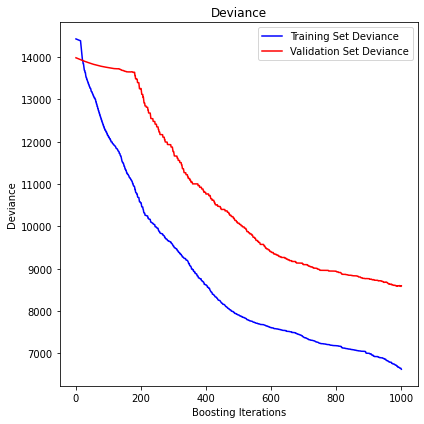

In [32]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_validate)):
    test_score[i] = reg.loss_(y_validate, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Validation Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

In [33]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

In [127]:
param_grid={
    'max_iter' :[100,200], 
    'min_samples_leaf' : [5, 20, 40], 
    'max_leaf_nodes' :[100, 200, 300], 
    'l2_regularization' : [0.1, 0.5, 0.9], 
    'verbose' : [1]
    }
n_jobs=2

In [128]:
def GradientBooster(param_grid, n_jobs): 
    estimator = HistGradientBoostingRegressor()
    cv = ShuffleSplit(train_size = 0.8, n_splits=10, test_size=0.2,)
    reg = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    reg.fit(X_train, y_train)

    print ("Best Estimator learned through GridSearch") 
    print (classifier.best_estimator_ )
    return cv, classifier.best_estimator_

In [ ]:
cv,best_est=GradientBooster(param_grid, n_jobs)

In [70]:
est = HistGradientBoostingRegressor(max_iter =100, 
                                    min_samples_leaf = 24, 
                                    max_leaf_nodes =300, 
                                    l2_regularization = 0.5, 
                                    verbose=1,).fit(X_train, y_train)
est.score(X_validate, y_validate)

Binning 0.029 GB of training data: 0.207 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 300 leaves, max depth = 19, in 0.109s
[2/100] 1 tree, 300 leaves, max depth = 21, in 0.125s
[3/100] 1 tree, 300 leaves, max depth = 19, in 0.118s
[4/100] 1 tree, 300 leaves, max depth = 20, in 0.124s
[5/100] 1 tree, 300 leaves, max depth = 22, in 0.114s
[6/100] 1 tree, 300 leaves, max depth = 25, in 0.119s
[7/100] 1 tree, 300 leaves, max depth = 21, in 0.133s
[8/100] 1 tree, 300 leaves, max depth = 20, in 0.118s
[9/100] 1 tree, 300 leaves, max depth = 23, in 0.123s
[10/100] 1 tree, 300 leaves, max depth = 22, in 0.118s
[11/100] 1 tree, 300 leaves, max depth = 22, in 0.121s
[12/100] 1 tree, 300 leaves, max depth = 21, in 0.117s
[13/100] 1 tree, 300 leaves, max depth = 24, in 0.126s
[14/100] 1 tree, 300 leaves, max depth = 22, in 0.120s
[15/100] 1 tree, 300 leaves, max depth = 23, in 0.126s
[16/100] 1 tree, 300 leaves, max depth = 19, in 0.129s
[17/100] 1 tree, 300 leaves, max depth = 22, in 0.134

0.29438108143727226

In [35]:
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer

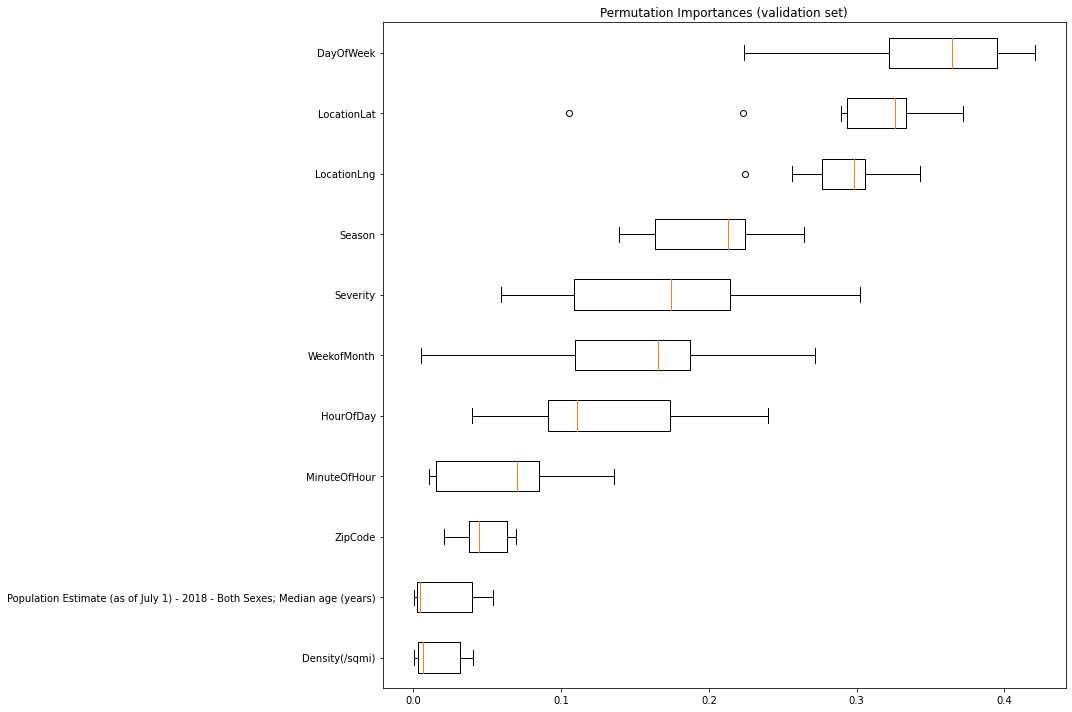

In [36]:
result = permutation_importance(est, X_validate, y_validate, n_repeats=10,
                                random_state=42, n_jobs=1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15, 10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

In [37]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(est, random_state=1).fit(X_validate, y_validate)
eli5.show_weights(perm, feature_names = X_validate.columns.tolist())

F:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Weight,Feature
0.3341 ± 0.0814,LocationLng
0.3158 ± 0.1995,DayOfWeek
0.2623 ± 0.1209,LocationLat
0.2086 ± 0.0412,Severity
0.1892 ± 0.0919,WeekofMonth
0.1402 ± 0.0651,HourOfDay
0.1233 ± 0.0870,Season
0.0907 ± 0.0528,MinuteOfHour
0.0555 ± 0.0237,ZipCode
0.0224 ± 0.0505,Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years)


In [38]:
X_validate

,Severity,LocationLat,LocationLng,ZipCode,Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),Density(/sqmi),DayOfWeek,Season,WeekofMonth,HourOfDay,MinuteOfHour
507453,2,47.29,-122.31,98003,36.90,870.90,4,3,2,2,3
242096,1,47.65,-122.32,98102,36.90,870.90,5,1,2,2,3
500659,1,47.43,-122.28,98188,36.90,870.90,6,3,0,2,3
458675,1,47.11,-118.58,99169,28.60,9.80,3,0,1,0,3
154109,3,47.62,-122.33,98102,36.90,870.90,3,3,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...
12304,1,47.67,-117.18,99037,37.60,267.80,1,3,3,2,3
431675,2,47.55,-122.13,98006,36.90,870.90,3,1,2,0,3
403562,3,46.25,-119.08,99301,30.30,66.80,4,1,2,1,3
231616,3,47.79,-122.32,98043,38.00,334.80,2,1,0,2,3


est.predict([[3, 47.70, -122.60, 5, 30, 20, 43]])

In [39]:
mse = mean_squared_error(y_validate, est.predict(X_validate))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 9095.8213


In [40]:
rms = sqrt(mse)
print('RMSE:', rms, '\n')

RMSE: 95.37201510148417 



##### xgboost

In [68]:
boost = xgb.XGBRegressor()
boost.fit(X_train,y_train)

[12:35:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [1]:
predictions = boost.predict(X_validate)
print(r2_score(predictions,y_validate))

NameError: name 'boost' is not defined

In [57]:
xgb1 = xgb.XGBRegressor()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03], #so called `eta` value
              'max_depth': [5],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:   21.3s finished


0.21405518419013247
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


## Supervised Deep Neural Networks

In [41]:
from sklearn.preprocessing import StandardScaler  # doctest: +SKIP
scaler = StandardScaler()  # doctest: +SKIP
# Don't cheat - fit only on training data
scaler.fit(X_train)  # doctest: +SKIP
X_train = scaler.transform(X_train)  # doctest: +SKIP
# apply same transformation to test data
X_test = scaler.transform(X_validate)  # doctest: +SKIP

In [42]:
from sklearn.neural_network import MLPRegressor

In [43]:
regr = MLPRegressor(random_state=1, max_iter=500, early_stopping=True, verbose=True).fit(X_train, y_train)

Iteration 1, loss = 7276.19657434
Validation score: 0.001787
Iteration 2, loss = 7004.45597307
Validation score: 0.005503
Iteration 3, loss = 6988.44186803
Validation score: 0.006727
Iteration 4, loss = 6979.86067782
Validation score: 0.007489
Iteration 5, loss = 6973.70542595
Validation score: 0.008015
Iteration 6, loss = 6970.22485760
Validation score: 0.008204
Iteration 7, loss = 6967.49884022
Validation score: 0.008659
Iteration 8, loss = 6965.46695799
Validation score: 0.008529
Iteration 9, loss = 6962.70690205
Validation score: 0.008708
Iteration 10, loss = 6962.51862720
Validation score: 0.009051
Iteration 11, loss = 6959.95208094
Validation score: 0.009167
Iteration 12, loss = 6959.14146910
Validation score: 0.009291
Iteration 13, loss = 6958.14878118
Validation score: 0.009329
Iteration 14, loss = 6956.88487081
Validation score: 0.009451
Iteration 15, loss = 6956.17472184
Validation score: 0.009598
Iteration 16, loss = 6954.81604772
Validation score: 0.009654
Iteration 17, los

Iteration 133, loss = 6895.56270178
Validation score: 0.014365
Iteration 134, loss = 6894.86259859
Validation score: 0.014317
Iteration 135, loss = 6894.79241150
Validation score: 0.014379
Iteration 136, loss = 6894.95005461
Validation score: 0.014083
Iteration 137, loss = 6894.18769000
Validation score: 0.014438
Iteration 138, loss = 6893.91809239
Validation score: 0.014620
Iteration 139, loss = 6893.34544386
Validation score: 0.014240
Iteration 140, loss = 6893.08854133
Validation score: 0.014738
Iteration 141, loss = 6892.75064653
Validation score: 0.014511
Iteration 142, loss = 6892.82164048
Validation score: 0.014425
Iteration 143, loss = 6891.94831914
Validation score: 0.014304
Iteration 144, loss = 6891.97642230
Validation score: 0.014678
Iteration 145, loss = 6892.08268841
Validation score: 0.014644
Iteration 146, loss = 6892.32791084
Validation score: 0.014550
Iteration 147, loss = 6891.32598754
Validation score: 0.014551
Iteration 148, loss = 6890.60251860
Validation score: 0

ValueError: Found input variables with inconsistent numbers of samples: [111501, 111499]

In [48]:
regr.score(X_test, y_validate)

0.0202006760231207

## Keras

In [37]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

Using TensorFlow backend.


In [38]:
import tensorflow as tf

In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Visible devices cannot be modified after being initialized


In [20]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

In [15]:
train, test = train_test_split(df_prune, test_size = 0.2)
target = train.Duration
train.drop(['Duration'],axis = 1 , inplace = True)

F:\Anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
# X, y = df_prune.drop('Duration',axis=1), df_prune['Duration']
# train, test = train_test_split(X, test_size = 0.2)

##### Do not run the line below, it's too GPU intensive to run on local machine

In [ ]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

In [18]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN_model.fit(train, target, epochs=50, batch_size=10, validation_split = 0.2, callbacks=callbacks_list)

In [ ]:
# Weights-488--18.80487.hdf5

In [ ]:
wights_file = './models/Weights-488--18.80487.hdf5'
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

Epoch 00499: val_loss did not improve from 18.80487
Epoch 500/500
357619/357619 [==============================] - 10s 29us/step - loss: 18.3375 - mean_absolute_error: 18.3375 - val_loss: 18.8967 - val_mean_absolute_error: 18.8967

r2_score(test.Duration, predictions)

0.0007101090759975559

# Conclusion

##### Best Model is Gradient Boosting

In [18]:
import pickle

In [28]:
pickle.dump(est, open("./models/GB_Duration.pickle.dat", "wb"))

In [19]:
# load model from file
loaded_model = pickle.load(open("./models/GB_Duration.pickle.dat", "rb"))

In [20]:
chk_anomaly = pd.DataFrame(loaded_model.predict(X_test))

In [24]:
len(chk_anomaly)

55879

In [23]:
chk_anomaly[chk_anomaly[0] >= 123]

,0
4,142.54
109,171.13
376,125.20
417,124.53
421,164.82
...,...
55307,142.12
55487,136.19
55543,174.27
55605,167.92
